<a href="https://colab.research.google.com/github/LaviRoars/pneumonia-detector/blob/main/Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import urllib.request
import tarfile

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import Dataset, Iterator

if not os.path.exists('./data/chest_xray'):
    os.makedirs('./data', exist_ok=True)
    urllib.request.urlretrieve("https://s3.eu-central-1.amazonaws.com/public.unit8.co/data/chest_xray.tar.gz", "data/chest_xray.tar.gz")
    tar = tarfile.open("data/chest_xray.tar.gz")
    tar.extractall(path='./data/')
    os.remove('data/chest_xray.tar.gz')

In [ ]:
glob.glob('./data/chest_xray/*/*')

['./data/chest_xray/val/PNEUMONIA',
 './data/chest_xray/val/NORMAL',
 './data/chest_xray/test/PNEUMONIA',
 './data/chest_xray/test/NORMAL',
 './data/chest_xray/train/PNEUMONIA',
 './data/chest_xray/train/NORMAL']

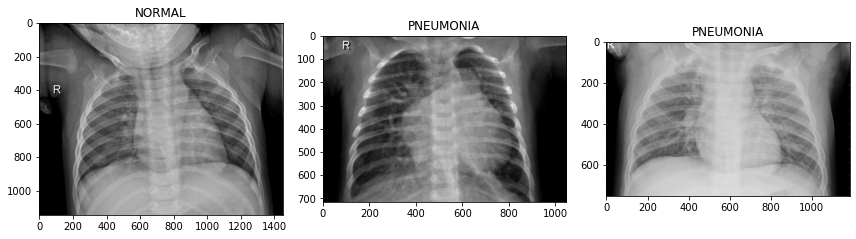

In [ ]:
img_normal = plt.imread('./data/chest_xray/train/NORMAL/IM-0131-0001.jpeg')
img_penumonia_bacteria = plt.imread('./data/chest_xray/train/PNEUMONIA/person1017_bacteria_2948.jpeg')
img_penumonia_virus = plt.imread('./data/chest_xray/train/PNEUMONIA/person1021_virus_1711.jpeg')

plt.figure(figsize=(12, 5))

plt.subplot(1,3,1).set_title('NORMAL')
plt.imshow(img_normal, cmap='gray')

plt.subplot(1,3,2).set_title('PNEUMONIA')
plt.imshow(img_penumonia_bacteria, cmap='gray')

plt.subplot(1,3,3).set_title('PNEUMONIA')
plt.imshow(img_penumonia_virus, cmap='gray')

plt.tight_layout()

In [ ]:
def get_labeled_files(folder):
    x = []
    y = []
    
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                continue # we do not investigate other dirs
            for image_filename in os.listdir(folder + folderName):
                img_path = folder + folderName + '/' + image_filename
                if img_path is not None and str.endswith(img_path, 'jpeg'):
                    x.append(img_path)
                    y.append(label)
    
    x = np.asarray(x)
    y = np.asarray(y)
    return x, y

In [ ]:
x, y = get_labeled_files('./data/chest_xray/train/')

list(zip(x, y))[:10]

[('./data/chest_xray/train/PNEUMONIA/person395_bacteria_1795.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person298_bacteria_1409.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person1391_bacteria_3537.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person420_bacteria_1850.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person263_bacteria_1227.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person295_bacteria_1390.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person1408_virus_2411.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person135_virus_270.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person1907_bacteria_4806.jpeg', 1),
 ('./data/chest_xray/train/PNEUMONIA/person911_bacteria_2836.jpeg', 1)]

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255)
bs=20
traindir = "./data/chest_xray/train/"
valdir = "./data/chest_xray/val/"
train_generator = datagen.flow_from_directory(
    traindir,
    target_size=(150, 150),
    batch_size=20
)

val_generator = datagen.flow_from_directory(
    valdir,
    target_size=(150, 150),
    batch_size=20
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [ ]:
for data_batch, label_batch in train_generator:
  print(data_batch.shape)
  print(label_batch.shape)
  break

(20, 150, 150, 3)
(20, 2)


In [ ]:
print(train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'NORMAL': 0, 'PNEUMONIA': 1}


In [ ]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Flatten, Dense
from keras.applications.vgg16 import VGG16

NUM_CLASSES = 2

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

x = base_model.output
x = Flatten()(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [ ]:
for layer in model.layers[0:20]:
    layer.trainable = False

optimizer = keras.optimizers.RMSprop()

model.compile(loss='categorical_crossentropy',     
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

# This callback saves the wieights of the model after each epoch
checkpoint = ModelCheckpoint(
    '/content/gdrive/My Drive/GAN/pneumonia_best_model.h5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    shuffle=True,
    callbacks=[checkpoint],
    epochs=20,
    verbose=1
)

Epoch 1/20
261/261 [==============================] - 1030s 4s/step - loss: 0.2618 - accuracy: 0.8894 - val_loss: 0.1629 - val_accuracy: 0.8750

Epoch 00001: val_loss improved from inf to 0.16286, saving model to /content/gdrive/My Drive/GAN/pneumonia_best_model.h5
Epoch 2/20
261/261 [==============================] - 1049s 4s/step - loss: 0.0909 - accuracy: 0.9691 - val_loss: 0.1283 - val_accuracy: 0.9375

Epoch 00002: val_loss improved from 0.16286 to 0.12829, saving model to /content/gdrive/My Drive/GAN/pneumonia_best_model.h5
Epoch 3/20
261/261 [==============================] - 1031s 4s/step - loss: 0.0693 - accuracy: 0.9722 - val_loss: 0.1433 - val_accuracy: 0.9375

Epoch 00003: val_loss did not improve from 0.12829
Epoch 4/20
261/261 [==============================] - 1031s 4s/step - loss: 0.0557 - accuracy: 0.9789 - val_loss: 0.3167 - val_accuracy: 0.8125

Epoch 00004: val_loss did not improve from 0.12829
Epoch 5/20
261/261 [==============================] - 1029s 4s/step - lo

In [ ]:
saved_model_dir = ''
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: assets


In [ ]:
from google.colab import files
files.download('model.tflite')
files.download('labels.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>